## Chapter 8: Water treatment part 1

In this chapter...

Let's have a look at the following reaction:

$$S+O_2 \rightarrow X+CO_2+NH_3+H_2O$$

Let's import the matrix:


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas
S = np.matrix(pandas.read_excel('mat1.xlsx'))


In [3]:
S

matrix([[ 1.  ,  0.  ,  1.  ,  1.  ,  0.  ,  0.  ],
        [ 1.8 ,  0.  ,  1.6 ,  0.  ,  2.  ,  3.  ],
        [ 0.75,  2.  ,  0.75,  2.  ,  1.  ,  0.  ],
        [ 0.11,  0.  ,  0.08,  0.  ,  0.  ,  1.  ],
        [ 0.  , -2.5 , -2.5 ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ]])

In [5]:
theta,mu=0.9,0.4   #max rates specified
C= np.matrix([0, 0, 0,0,theta,mu]).T
r = np.linalg.solve(S, C)
r

matrix([[-1.15465995],
        [-0.76      ],
        [ 0.4       ],
        [ 0.75465995],
        [ 0.57667506],
        [ 0.09501259]])

Let's define the rate function


In [37]:
mumax=0.1
Co_sat=7/1000/32
Ko=Co_sat*0.15
thetamax=0.9
Ks=0.003
kla=100*24/500 #per day

def response_fun(t,C):
    
    Cs, Co, Cx, Cc, Cn = C[0],C[1],C[2],C[3],C[4]   #Considered components
    
    mu=mumax*(Cs/(Ks+Cs))*(Co/(Ko+Co))        #this terms reduces mu or theta as substrate becomes limited, more about this later
    theta=thetamax*(Cs/(Ks+Cs))*(Co/(Ko+Co))

    C= np.matrix([0, 0, 0,0,theta,mu]).T
    r = np.linalg.solve(S, C) 
    
        
    return [r[0,0]*Cx,   # glucose-substrate S
            r[1,0]*Cx+kla*(Co_sat-Co),   # oxygen
            r[2,0]*Cx,   # biomass
            r[3,0]*Cx,    #CO2
            r[5,0]*Cx]   # ammonia  

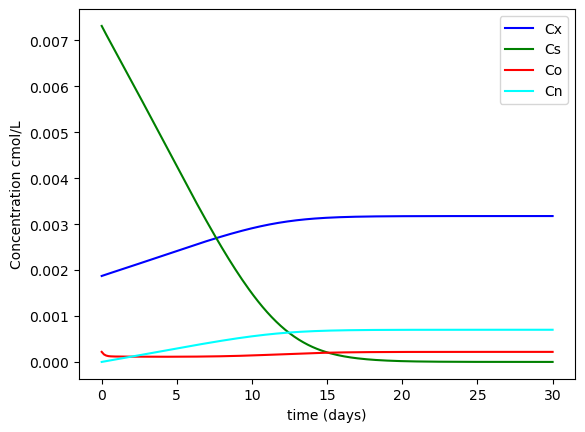

In [38]:
from scipy.integrate import solve_ivp

MM_S=12+S[1,0]+S[2,0]*16+S[3,0]*14
MM_X=12+S[1,2]+S[2,2]*16+S[3,2]*14

Co=[0.2/MM_S,Co_sat,0.05/MM_X,0,0]             #initial cmol value of S,X,A,P
                      
tmax = 30                               # time to integrate to  
tspan=np.linspace(0,tmax,200)            # define the timespan of the integration and increments where values will be reported
tper = (0,tmax)                          #defining the starting and end time for the solve_IVP function

Ci = solve_ivp(response_fun, tper, Co, dense_output = True, method = "LSODA")    # integration via odeint that calls apon response_fun

Cs, Co, Cx, Cc, Cn = Ci.sol(tspan)

plt.figure(3)
plt.plot(tspan, Cx, color='blue', label='Cx')
plt.plot(tspan, Cs, color='green', label='Cs')
plt.plot(tspan, Co, color='red', label='Co')
plt.plot(tspan, Cn, color='cyan', label='Cn')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (days)') 
plt.show() 

Let's try a continous model:


In [63]:
mumax=0.1
Co_sat=7/1000/32
Ko=Co_sat*0.15
thetamax=0.9
Ks=0.003
kla=100*24/1500 #per day

def response_fun(C):
    
    Cs, Co, Cx, Cn = C[0],C[1],C[2],C[3]   #Considered components
    
    mu=mumax*(Cs/(Ks+Cs))*(Co/(Ko+Co))        #this terms reduces mu or theta as substrate becomes limited, more about this later
    theta=thetamax*(Cs/(Ks+Cs))*(Co/(Ko+Co))

    C= np.matrix([0, 0, 0,0,theta,mu]).T
    r = np.linalg.solve(S, C) 
    
        
    return [r[0,0],   # glucose-substrate S
            r[1,0],   # oxygen
            r[2,0],   # biomass
            r[5,0]]   # ammonia  

Let's have a look at the cmol balance for biomass:

\begin{align*}
\frac{dC_i}{dt} &= D(C^F_i - C_i) + r_i C_X \\
\end{align*}

In [64]:

def ferm_eq(t,C):
    Cs, Co, Cx, Cn = C[0],C[1],C[2],C[3]   #Considered components 
    r=response_fun([Cs, Co, Cx, Cn])      # this is the 'fetching' from the response function
    
    return [r[0]*Cx+D*(Cfs-Cs),              #gluc
            r[1]*Cx+kla*(Co_sat-Co)+D*(Cfo-Co),  #o2
            r[2]*Cx+D*(Cfx-Cx),                #x
            r[3]*Cx-D*Cn]                    #n

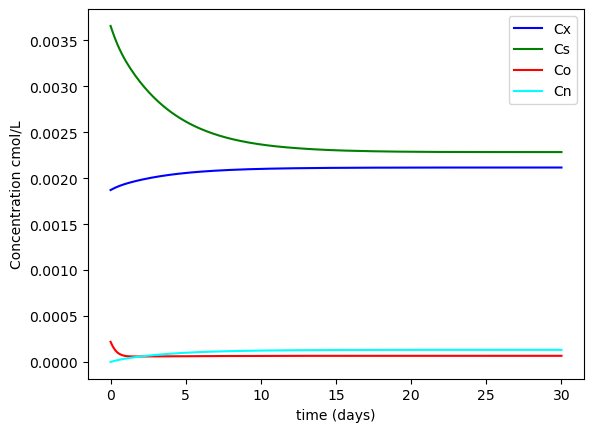

In [65]:
D=1/4
Cfs=0.1/MM_S
Cfo=Co_sat
Cfx=0.05/MM_X
Cf=[0.1/MM_S,Co_sat,0,0]
Co=[0.1/MM_S,Co_sat,0.05/MM_X,0]

tmax = 30                               # time to integrate to  
tspan=np.linspace(0,tmax,200)            # define the timespan of the integration and increments where values will be reported
tper = (0,tmax)                          #defining the starting and end time for the solve_IVP function

Ci = solve_ivp(ferm_eq, tper, Co, dense_output = True, method = "LSODA")    # integration via odeint that calls apon response_fun

Cs, Co, Cx, Cn = Ci.sol(tspan)

plt.figure(3)
plt.plot(tspan, Cx, color='blue', label='Cx')
plt.plot(tspan, Cs, color='green', label='Cs')
plt.plot(tspan, Co, color='red', label='Co')
plt.plot(tspan, Cn, color='cyan', label='Cn')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (days)') 
plt.show() 

In [49]:
Cf

[0.00365764447695684, 0.00021875, 0, 0]

In [50]:
Cf[0]

0.00365764447695684